# Facial Keypoint Detection
  
This project will be all about defining and training a convolutional neural network to perform facial keypoint detection, and using computer vision techniques to transform images of faces.

Let's take a look at some examples of images and corresponding facial keypoints.

<img src='images/key_pts_example.png' width=50% height=50%/>

Facial keypoints (also called facial landmarks) are the small magenta dots shown on each of the faces in the image above. In each training and test image, there is a single face and **68 keypoints, with coordinates (x, y), for that face**.  These keypoints mark important areas of the face: the eyes, corners of the mouth, the nose, etc. These keypoints are relevant for a variety of tasks, such as face filters, emotion recognition, pose recognition, and so on. Here they are, numbered, and you can see that specific ranges of points match different portions of the face.

<img src='images/landmarks_numbered.jpg' width=30% height=30%/>


## Load and Visualize Data
The data is about the face images of people on Youtube. the data has been taken from website [https://www.cs.tau.ac.il/~wolf/ytfaces/] it's a Youtube Face DataBase. in which you have to login first to get files downloaded. This dataset is image frames from videos of people uploaded on youtube. These image frames has been under image processing in which they have faces and with specific keypoints on it.

#### Training and Testing Data

This facial keypoints dataset consists of 5770 color images. All of these images are separated into either a training or a test set of data.

* 3462 of these images are training images, for you to use as you create a model to predict keypoints.
* 2308 are test images, which will be used to test the accuracy of your model.

The information about the images and keypoints in this dataset are summarized in CSV files.There are two files one is for training and other one is for testing dataset.In the file there are annotations in an (N, 2) array where N is the number of keypoints and 2 is the dimension of the keypoint coordinates (x, y).

In [1]:
# import the required libraries
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import cv2

In [2]:
#Then, let's load in our training data and display some stats about that dat ato make sure it's been loaded in correctly!

key_pts_frame = pd.read_csv('C:/Users/jagri/Downloads/Project-Facial-Keypoint-Detection-master/Project-Facial-Keypoint-Detection-master/data/training_frames_keypoints.csv')

n = 0
image_name = key_pts_frame.iloc[n, 0]
key_pts = key_pts_frame.iloc[n, 1:].to_numpy()
key_pts = key_pts.astype('float').reshape(-1, 2)

print('Image name: ', image_name)
print('Landmarks shape: ', key_pts.shape)
print('First 4 key pts: {}'.format(key_pts[:4]))

Image name:  Luis_Fonsi_21.jpg
Landmarks shape:  (68, 2)
First 4 key pts: [[ 45.  98.]
 [ 47. 106.]
 [ 49. 110.]
 [ 53. 119.]]


In [3]:
print('Number of images: ', key_pts_frame.shape[0])

Number of images:  3462


These images are not at all in same size. so to run neaural network, we have standardize their shape.

In [4]:
def show_keypoints(image, key_pts):
    plt.imshow(image)
    plt.scatter(key_pts[:, 0], key_pts[:, 1], s=20, marker='.', c='m')

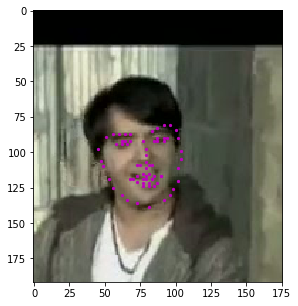

In [5]:
n = 0
image_name = key_pts_frame.iloc[n, 0]
key_pts = key_pts_frame.iloc[n, 1:].to_numpy()
key_pts = key_pts.astype('float').reshape(-1, 2)

plt.figure(figsize=(5, 5))
show_keypoints(mpimg.imread(os.path.join('C:/Users/jagri/Downloads/Project-Facial-Keypoint-Detection-master/Project-Facial-Keypoint-Detection-master/data/training/', image_name)), key_pts)
plt.show()

## Dataset class and Transformations
To prepare our data for training, we'll be using PyTorch's Dataset class.

#### Dataset class

``torch.utils.data.Dataset`` is an abstract class representing a
dataset. This class will allow us to load batches of image/keypoint data, and uniformly apply transformations to our data, such as rescaling and normalizing images for training a neural network.

create a dataset class for our face keypoints dataset. We will
read the CSV file in ``__init__`` but leave the reading of images to
``__getitem__``. This is memory efficient because all the images are not
stored in the memory at once but read as required.

In [6]:
from torch.utils.data import Dataset, DataLoader

class FacialKeypointsDataset(Dataset):


    def __init__(self, csv_file, root_dir, transform=None):
        self.key_pts_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.key_pts_frame)

    def __getitem__(self, idx):
        image_name = os.path.join(self.root_dir,
                                self.key_pts_frame.iloc[idx, 0])
        
        image = mpimg.imread(image_name)
        
        # getting rid of alpha channel, if any
        if(image.shape[2] == 4):
            image = image[:,:,0:3]
        
        key_pts = self.key_pts_frame.iloc[idx, 1:].to_numpy()
        key_pts = key_pts.astype('float').reshape(-1, 2)
        sample = {'image': image, 'keypoints': key_pts}

        if self.transform:
            sample = self.transform(sample)

        return sample

Display of images

In [7]:
face_dataset = FacialKeypointsDataset(csv_file='C:/Users/jagri/Downloads/Project-Facial-Keypoint-Detection-master/Project-Facial-Keypoint-Detection-master/data/training_frames_keypoints.csv',
                                      root_dir='C:/Users/jagri/Downloads/Project-Facial-Keypoint-Detection-master/Project-Facial-Keypoint-Detection-master/data/training/')

print('Length of dataset: ', len(face_dataset))

Length of dataset:  3462


0 (372, 368, 3) (68, 2)
1 (268, 228, 3) (68, 2)
2 (146, 116, 3) (68, 2)


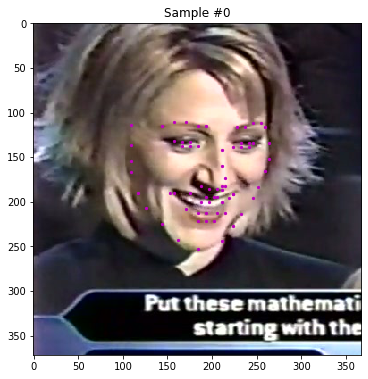

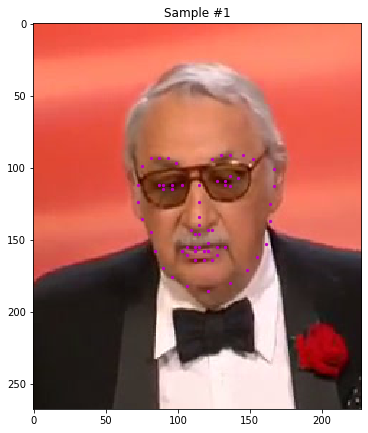

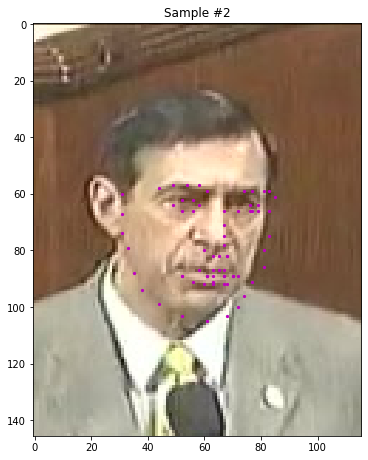

In [8]:

num_to_display = 3

for i in range(num_to_display):

    fig = plt.figure(figsize=(20,10))

    rand_i = np.random.randint(0, len(face_dataset))
    sample = face_dataset[rand_i]

    print(i, sample['image'].shape, sample['keypoints'].shape)

    ax = plt.subplot(1, num_to_display, i + 1)
    ax.set_title('Sample #{}'.format(i))
    
    show_keypoints(sample['image'], sample['keypoints'])


## Transforms

Now, the images above are not of the same size, and neural networks often expect images that are standardized; a fixed size, with a normalized range for color ranges and coordinates, and (for PyTorch) converted from numpy lists and arrays to Tensors.

Therefore, some pre-processing code.
Let's create four transforms:

-  ``Normalize``: to convert a color image to grayscale values with a range of [0,1] and normalize the keypoints to be in a range of about [-1, 1]
-  ``Rescale``: to rescale an image to a desired size.
-  ``RandomCrop``: to crop an image randomly.
-  ``ToTensor``: to convert numpy images to torch images.


We will write them as callable classes instead of simple functions so
that parameters of the transform need not be passed everytime it's
called. For this, we just need to implement ``__call__`` method and 
(if we require parameters to be passed in), the ``__init__`` method. 
We can then use a transform like this:

    tx = Transform(params)
    transformed_sample = tx(sample)

Observe below how these transforms are generally applied to both the image and its keypoints.


In [9]:
import torch
from torchvision import transforms, utils

# tranforms

class Normalize(object):
    """Convert a color image to grayscale and normalize the color range to [0,1]."""        

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']
        
        image_copy = np.copy(image)
        key_pts_copy = np.copy(key_pts)

        # convert image to grayscale
        image_copy = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        
        # scale color range from [0, 255] to [0, 1]
        image_copy=  image_copy/255.0
        
        # scale keypoints to be centered around 0 with a range of [-1, 1]
        # mean = 100, sqrt = 50, so, pts should be (pts - 100)/50
        key_pts_copy = (key_pts_copy - 100)/50.0


        return {'image': image_copy, 'keypoints': key_pts_copy}


class Rescale(object):
    """Rescale the image in a sample to a given size.
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = cv2.resize(image, (new_w, new_h))
        
        # scale the pts, too
        key_pts = key_pts * [new_w / w, new_h / h]

        return {'image': img, 'keypoints': key_pts}


class RandomCrop(object):
    """Crop randomly the image in a sample.
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        key_pts = key_pts - [left, top]

        return {'image': image, 'keypoints': key_pts}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']
         
        # if image has no grayscale color channel, add one
        if(len(image.shape) == 2):
            # add that third color dim
            image = image.reshape(image.shape[0], image.shape[1], 1)
            
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        
        return {'image': torch.from_numpy(image),
                'keypoints': torch.from_numpy(key_pts)}

## Test out the transforms

Let's test these transforms out to make sure they behave as expected. 

**order of image matter**  as we cannot crop image using a value smaller than the original image, so we will rescale the original image, so that we can crop it in small size.

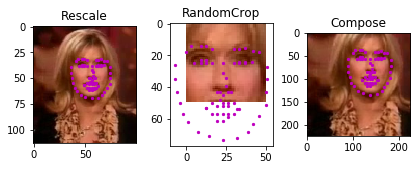

In [10]:
# test out some of these transforms
rescale = Rescale(100)
crop = RandomCrop(50)
composed = transforms.Compose([Rescale(250),
                               RandomCrop(224)])

# apply the transforms to a sample image
test_num = 500
sample = face_dataset[test_num]

fig = plt.figure()
for i, tx in enumerate([rescale, crop, composed]):
    transformed_sample = tx(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tx).__name__)
    show_keypoints(transformed_sample['image'], transformed_sample['keypoints'])

plt.show()

## Create the transformed dataset

The transforms are in order to get grayscale images of the same shape.

In [11]:
# define the data tranform
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose([Rescale(250),
                                     RandomCrop(224),
                                     Normalize(),
                                     ToTensor()])

# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='C:/Users/jagri/Downloads/Project-Facial-Keypoint-Detection-master/Project-Facial-Keypoint-Detection-master/data/training_frames_keypoints.csv',
                                             root_dir='C:/Users/jagri/Downloads/Project-Facial-Keypoint-Detection-master/Project-Facial-Keypoint-Detection-master/data/training/',
                                             transform=data_transform)


In [12]:
# print some stats about the transformed data
print('Number of images: ', len(transformed_dataset))

# make sure the sample tensors are the expected size
for i in range(5):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())


Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])
4 torch.Size([1, 224, 224]) torch.Size([68, 2])


## Define the Convolutional Neural Network

After loading and having a brief about data, here we are now trying to implement our model of Convolutional Neural Network.

In this notebook and in `models.py`, we will:
1. Define a CNN with images as input and keypoints as output
2. Construct the transformed FaceKeypointsDataset, just as before
3. Train the CNN on the training data, tracking loss
4. See how the trained model performs on test data
5. If necessary, modify the CNN structure and model hyperparameters, so that it performs *well* **\***



## CNN Architecture

CNN's are defined by a few types of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected layers

### TODO: Define your model in the provided file `models.py` file

This file is mostly empty but contains the expected name and some TODO's for creating our model.

---

## PyTorch Neural Nets

To define a neural network in PyTorch, we have to define the layers of a model in the function `__init__` and define the feedforward behavior of a network that employs those initialized layers in the function `forward`, which takes in an input image tensor, `x`. The structure of this Net class is shown below and left for you to fill in.

Note: During training, PyTorch will be able to perform backpropagation by keeping track of the network's feedforward behavior and using autograd to calculate the update to the weights in the network.

#### Define the Layers in ` __init__`

```
# 1 input image channel (for grayscale images), 32 output channels/feature maps, 3x3 square convolution kernel

# maxpool that uses a square window of kernel_size=2, stride=2
    
```

#### Refer to Layers in `forward`
Then referred to in the `forward` function like this, in which the conv1 layer has a ReLu activation applied to it before maxpooling is applied:
```

```

#### Why models.py

Task of defining the network in the `models.py` file so that any models we define can be saved and loaded by name in different notebooks in this project directory.


In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from models import Net #uncomment this after changing model.py
net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(256, 512, kernel_size=(1, 1), stride=(1, 1))
  (pool5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=18432, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=136, bias=True)
  (drop1): Dropout(p=0.1, inplace=False)
  (drop2): Dropout(p=0.2,

## Transform the dataset 

To prepare for training, we created a transformed dataset of images and keypoints.

### TODO: Define a data transform

In PyTorch, a convolutional neural network expects a torch image of a consistent size as input. The necessary transforms have been defined in `data_load.py`.

To define the data transform below, use a composition of:
1. Rescaling and/or cropping the data, such that you are left with a square image (the suggested size is 224x224px)
2. Normalizing the images and keypoints; turning each RGB image into a grayscale image with a color range of [0, 1] and transforming the given keypoints into a range of [-1, 1]
3. Turning these images and keypoints into Tensors

**This transform will be applied to the training data and, later, the test data**.


In [14]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from data_load import FacialKeypointsDataset
from data_load import Rescale, RandomCrop, Normalize, ToTensor

data_transform = transforms.Compose([Rescale(250),
                                     RandomCrop(224),
                                     Normalize(),
                                     ToTensor()])

## Rescale -> Croping -> Normalize -> convert to tensor

assert(data_transform is not None), 'Define a data_transform'

In [15]:
# creation the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='C:/Users/jagri/Downloads/Project-Facial-Keypoint-Detection-master/Project-Facial-Keypoint-Detection-master/data/training_frames_keypoints.csv',
                                             root_dir='C:/Users/jagri/Downloads/Project-Facial-Keypoint-Detection-master/Project-Facial-Keypoint-Detection-master/data/training/',
                                             transform=data_transform)


print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


## Batching and loading data

Next, having defined the transformed dataset, we can use PyTorch's DataLoader class to load the training data in batches of whatever size as well as to shuffle the data for training the model. .


In [16]:
# load training data in batches
batch_size = 16

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)


In [17]:
# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='C:/Users/jagri/Downloads/Project-Facial-Keypoint-Detection-master/Project-Facial-Keypoint-Detection-master/data/test_frames_keypoints.csv',
                                      root_dir='C:/Users/jagri/Downloads/Project-Facial-Keypoint-Detection-master/Project-Facial-Keypoint-Detection-master/data/test',
                                      transform=data_transform)



In [18]:
# load test data in batches
batch_size = 16

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)

## Apply the model on a test sample

To test the model on a test sample of data, you have to follow these steps:
1. Extract the image and ground truth keypoints from a sample
2. Wrap the image in a Variable, so that the net can process it as input and track how it changes as the image moves through the network.
3. Make sure the image is a FloatTensor, which the model expects.
4. Forward pass the image through the net to get the predicted, output keypoints.

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [19]:
# test the model on a batch of test images

def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor)

        # forward pass to get net output
        output_pts = net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts
            

In [20]:
# calling the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([16, 1, 224, 224])
torch.Size([16, 68, 2])
torch.Size([16, 68, 2])


## Visualize the predicted keypoints

Once we've had the model produce some predicted output keypoints, we can visualize these points in a way that's similar to how we've displayed this data before, only this time, we have to "un-transform" the image/keypoint data to display it.

In [21]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


Helper function. `visualize_output` that takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

This function's main role is to take batches of image and keypoint data (the input and output of your CNN), and transform them into numpy images and un-normalized keypoints (x, y) for normal display. The un-transformation process turns keypoints and images into numpy arrays from Tensors *and* it undoes the keypoint normalization done in the Normalize() transform

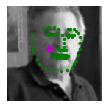

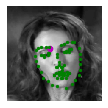

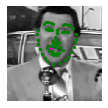

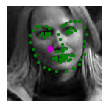

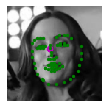

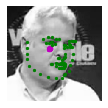

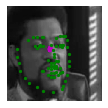

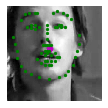

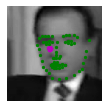

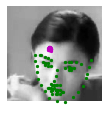

In [22]:
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's Variable wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts)

## Training

#### Loss function
Training a network to predict keypoints is different than training a network to predict a class; instead of outputting a distribution of classes and using cross entropy loss, you may want to choose a loss function that is suited for regression, which directly compares a predicted value and target value.

In [23]:
import torch.optim as optim

criterion = nn.MSELoss()

optimizer = optim.Adam(params = net.parameters(), lr = 0.001)

## Test data
Now we are testing our data based on pre-defined mode, we have already loaded and transformer the data, similar to training data.

In [24]:
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([16, 1, 224, 224])
torch.Size([16, 68, 2])
torch.Size([16, 68, 2])


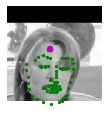

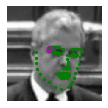

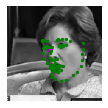

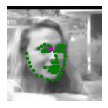

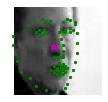

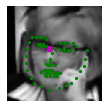

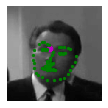

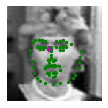

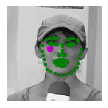

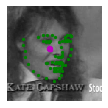

In [25]:
# visualize_output(test_images, test_outputs, gt_pts)
visualize_output(test_images, test_outputs, gt_pts)

In [26]:
## TODO: change the name to something uniqe for each new model
model_dir = 'saved_models/'
model_name = 'keypoints_model_1.pt'
# after training, save your model parameters in the dir 'saved_models
torch.save(net.state_dict(), model_dir+model_name)

## Feature Visualization

neural networks are thought of as a black box, given some input, they learn to produce some output. CNN's are actually learning to recognize a variety of spatial patterns and you can visualize what each convolutional layer has been trained to recognize by looking at the weights that make up each convolutional kernel and applying those one at a time to a sample image. This technique is called feature visualization and it's useful for understanding the inner workings of a CNN.

[[-0.15961862  0.15572824 -0.02720264  0.04950511  0.0906512 ]
 [-0.19353437  0.11764301  0.04298314  0.1565953   0.06551294]
 [-0.12931174 -0.05101304 -0.07436506 -0.06651933  0.1395282 ]
 [-0.01414225 -0.09818335  0.14330281 -0.17040114 -0.0731189 ]
 [-0.15464911  0.10970859  0.13779242 -0.18028402  0.14857994]]
(5, 5)


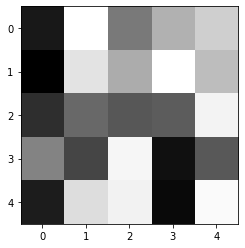

In [27]:
# Get the weights in the first conv layer, "conv1"
weights1 = net.conv1.weight.data

w = weights1.numpy()

filter_index = 0

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')


## Feature maps

Each CNN has at least one convolutional layer that is composed of stacked filters (also known as convolutional kernels). As a CNN trains, it learns what weights to include in it's convolutional kernels and when these kernels are applied to some input image, they produce a set of feature maps. So, feature maps are just sets of filtered images; they are the images produced by applying a convolutional kernel to an input image. These maps show us the features that the different layers of the neural network learn to extract.

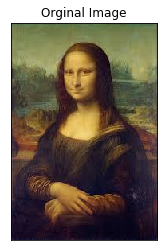

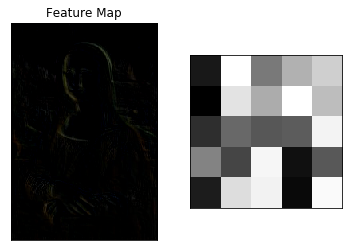

In [28]:
##TODO: load in and displaying any image from the transformed test dataset

import cv2

image = cv2.imread('./images/mona_lisa.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.xticks([]), plt.yticks([])
plt.title("Orginal Image")

filtered = cv2.filter2D(image, -1, w[filter_index][0])

# Visualization
fig = plt.figure()
ax = fig.add_subplot(121, xticks = [], yticks = [])
ax.imshow(filtered)
ax.set_title("Feature Map")
ax = fig.add_subplot(122, xticks = [], yticks = [])
ax.imshow(w[filter_index][0], cmap = 'gray')

plt.show()

## Face and Facial Keypoint detection

After training a neural network to detect facial keypoints, we can then apply this network to any image that includes faces. The neural network expects a Tensor of a certain size as input and, so, to detect any face,we have first done some pre-proecessing.

1. Detect all the faces in an image using a face detector (we'll be using a Haar Cascade detector in this notebook).
2. Pre-process those face images so that they are grayscale, and transformed to a Tensor of the input size that your net expects. This step will be similar to the `data_transform` you created and applied in Notebook 2, whose job was tp rescale, normalize, and turn any iimage into a Tensor to be accepted as input to your CNN.
3. Use your trained model to detect facial keypoints on the image.

---

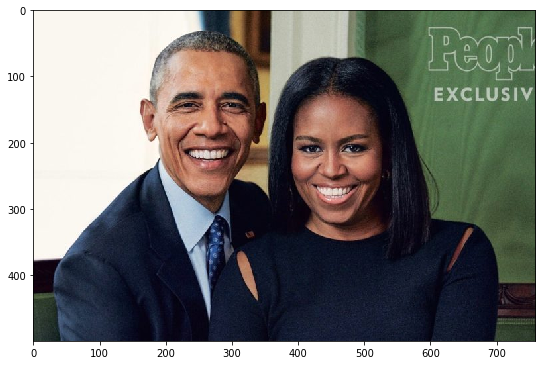

In [29]:
import cv2
image = cv2.imread('images/obamas.jpg')

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

fig = plt.figure(figsize=(9,9))
plt.imshow(image)

## Detect all faces in an image

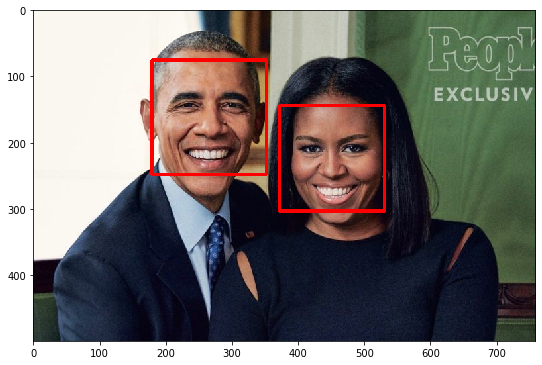

In [30]:
# load in a haar cascade classifier for detecting frontal faces
face_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_frontalface_default.xml')

# run the detector
# the output here is an array of detections; the corners of each detection box
# if necessary, modify these parameters until you successfully identify every face in a given image
faces = face_cascade.detectMultiScale(image, 1.2, 2)

# make a copy of the original image to plot detections on
image_with_detections = image.copy()

# loop over the detected faces, mark the image where each face is found
for (x,y,w,h) in faces:
    # draw a rectangle around each detected face
    # you may also need to change the width of the rectangle drawn depending on image resolution
    cv2.rectangle(image_with_detections,(x,y),(x+w,y+h),(255,0,0),3) 

fig = plt.figure(figsize=(9,9))

plt.imshow(image_with_detections)

## Loading in a trained model

In [31]:
import torch
from models import Net

net = Net()

## TODO: load the best saved model parameters (by your path name)
net.load_state_dict(torch.load('saved_models/keypoints_model_1.pt'))

net.eval()

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(256, 512, kernel_size=(1, 1), stride=(1, 1))
  (pool5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=18432, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=136, bias=True)
  (drop1): Dropout(p=0.1, inplace=False)
  (drop2): Dropout(p=0.2,

## Keypoint detection


### TODO: Transform each detected face into an input Tensor

1. Convert the face from RGB to grayscale
2. Normalize the grayscale image so that its color range falls in [0,1] instead of [0,255]
3. Rescale the detected face to be the expected square size for your CNN (224x224, suggested)
4. Reshape the numpy image into a torch image.

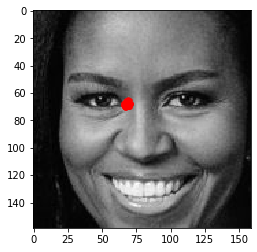

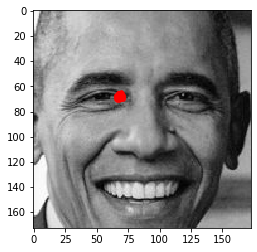

In [32]:
image_copy = np.copy(image)
from torch.autograd import Variable
# helper fuction to plot images
def showpoints(image,keypoints):
    
    plt.figure()
    
    keypoints = keypoints.data.numpy()
    keypoints = keypoints * 60.0 + 68
    keypoints = np.reshape(keypoints, (68, -1))
    
    plt.imshow(image, cmap='gray')
    plt.scatter(keypoints[:, 0], keypoints[:, 1], s=50, marker='.', c='r')


    
    from torch.autograd import Variable
image_copy = np.copy(image)

for (x,y,w,h) in faces:
    roi = image_copy[y:y+h,x:x+w]
    roi = cv2.cvtColor(roi, cv2.COLOR_RGB2GRAY)
    image = roi
    roi = roi/255.0
    roi = cv2.resize(roi, (224,224))
    roi = np.expand_dims(roi, 0)
    roi = np.expand_dims(roi, 0)
    roi_torch = Variable(torch.from_numpy(roi))
    roi_torch = roi_torch.type(torch.FloatTensor)
    keypoints = net(roi_torch)  
    showpoints(image,keypoints)

## Facial Filters

Using our trained facial keypoint detector,we can now do things like add filters to a person's face, automatically. Here we are now trying to add sunglasses on someone's face.

<img src="images/face_filter_ex.png" width=60% height=60%/>

Let's start this process by looking at a sunglasses .png that we'll be working with!

Image shape:  (1123, 3064, 4)


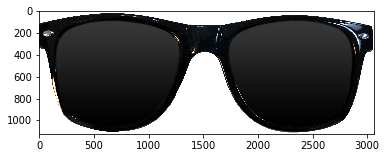

In [33]:
sunglasses = cv2.imread('images/sunglasses.png', cv2.IMREAD_UNCHANGED)
plt.imshow(sunglasses)
print('Image shape: ', sunglasses.shape)

The alpha channel looks like this (black pixels = transparent): 


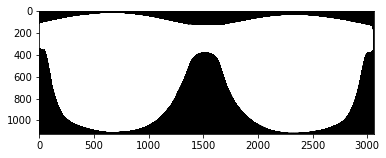

In [34]:
# print out the sunglasses transparency (alpha) channel
alpha_channel = sunglasses[:,:,3]
print ('The alpha channel looks like this (black pixels = transparent): ')
plt.imshow(alpha_channel, cmap='gray')

In [35]:
values = np.where(alpha_channel != 0)
print ('The non-zero values of the alpha channel are: ')
print (values)

The non-zero values of the alpha channel are: 
(array([  17,   17,   17, ..., 1109, 1109, 1109], dtype=int64), array([ 687,  688,  689, ..., 2376, 2377, 2378], dtype=int64))


#### Overlaying images

This means that when we place this sunglasses image on top of another image, we can use the transparency channel as a filter:

* If the pixels are non-transparent (alpha_channel > 0), overlay them on the new image

#### Keypoint locations

In doing this, it's helpful to understand which keypoint belongs to the eyes, mouth, etc., so in the image below we also print the index of each facial keypoint directly on the image so you can tell which keypoints are for the eyes, eyebrows, etc.,

<img src="images/landmarks_numbered.jpg" width=50% height=50%/>

It may be useful to use keypoints that correspond to the edges of the face to define the width of the sunglasses, and the locations of the eyes to define the placement.

In [36]:
key_pts_frame = pd.read_csv('C:/Users/jagri/Downloads/Project-Facial-Keypoint-Detection-master/Project-Facial-Keypoint-Detection-master/data/training_frames_keypoints.csv')

print('Number of images: ', key_pts_frame.shape[0])

Number of images:  3462


In [37]:
def show_keypoints(image, key_pts):

    plt.imshow(image)
    plt.scatter(key_pts[:, 0], key_pts[:, 1], s=20, marker='.', c='m')


Image name:  Alfredo_di_Stefano_50.jpg


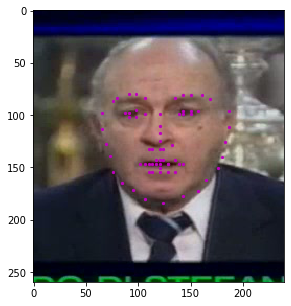

In [38]:
n = 176
image_name = key_pts_frame.iloc[n, 0]
image = mpimg.imread(os.path.join('C:/Users/jagri/Downloads/Project-Facial-Keypoint-Detection-master/Project-Facial-Keypoint-Detection-master/data/training/', image_name))
key_pts = key_pts_frame.iloc[n, 1:].to_numpy()
key_pts = key_pts.astype('float').reshape(-1, 2)

print('Image name: ', image_name)

plt.figure(figsize=(5, 5))
show_keypoints(image, key_pts)
plt.show()

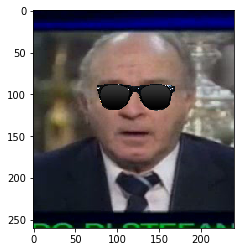

In [39]:
image_copy = np.copy(image)
x = int(key_pts[17, 0])
y = int(key_pts[17, 1])
h = int(abs(key_pts[27,1] - key_pts[34,1]))
w = int(abs(key_pts[17,0] - key_pts[26,0]))
sunglasses = cv2.imread('images/sunglasses.png', cv2.IMREAD_UNCHANGED)
new_sunglasses =  cv2.resize(sunglasses, (w, h), interpolation = cv2.INTER_CUBIC)
roi_color = image_copy[y:y+h,x:x+w]
ind = np.argwhere(new_sunglasses[:,:,3] > 0)
for i in range(3):
    roi_color[ind[:,0],ind[:,1],i] = new_sunglasses[ind[:,0],ind[:,1],i]    
image_copy[y:y+h,x:x+w] = roi_color
plt.imshow(image_copy)

# THANKYOU

#### Team Members:
###### Jagrit Khanduja (18csu093)
###### Ishwar Manral (18csu092)
###### Dhruv Indoria (18csu100)
###### Heemanshu (18csu094)

## References:
```
Google
Github
Coursera

```